In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
# output file
out_f <- 'fuji.input.tsv'

# input file/dir
traitlist_f <- 'traitlist.tsv'
in_d <- '@@@@@@/users/ytanigaw/repos/rivas-lab/biomarkers/cascade/out_v3'


In [3]:
dfs <- list()
for(vtype in c('PTVs', 'PAVs', 'nc')){
    dfs[[vtype]] <- fread(file.path(in_d, sprintf('cascade.%s.tsv', vtype))) %>% rename('CHROM'='#CHROM')
}


In [4]:
traitlist_df <- fread(traitlist_f) %>% rename('Phenotype'='#Phenotype')


In [5]:
df <- bind_rows(
    dfs[['PTVs']] %>% mutate(Csq='PTVs'),
    dfs[['PAVs']] %>% mutate(Csq='PAVs')
) %>%
select(CHROM, POS, ID, trait, Gene_symbol, BETA, MAF, Csq) %>%
bind_rows(
    dfs[['nc']] %>%
    replace_na(list(Gene_symbol=''))%>%
    select(CHROM, POS, ID, trait, BETA, MAF) %>%
    mutate(Gene_symbol='', Csq='nc')
) %>%
rename(
    'CHR' = 'CHROM',
    'BP' = 'POS',
    'GENE' = 'Gene_symbol',    
    'MARKER' = 'ID'
) %>%
left_join(traitlist_df, by=c('trait'='Phenotype'))


In [6]:
most_common = function(x) {tail(names(sort(table(x))), 1)}


In [7]:
locus_all_df <- df %>%
select(CHR, BP, MARKER, GENE) %>% 
unique() %>%
arrange(CHR, BP) %>%
unique() %>%
mutate(LOCUS_ID=1:n())

locus_label_df <- df %>%
filter(Csq%in%c('PTVs', 'PAVs'), abs(BETA) > .1, GENE!='') %>%
group_by(CHR, GENE) %>%
summarize(
    plot_CHR = most_common(CHR),
    plot_BP = most_common(BP)
) %>%
ungroup()

locus_df <- locus_all_df %>%
left_join(
    locus_label_df, by=c('CHR', 'GENE')
) %>%
mutate(
    GENE = if_else((CHR == plot_CHR) & (BP == plot_BP), GENE, '')
) %>%
replace_na(list(GENE=''))%>%
select(-plot_CHR, -plot_BP)


In [8]:
dim(locus_df)

[1] 5796    5

In [9]:
df %>% count(Csq)

Csq,n
<chr>,<int>
nc,9119
PAVs,1323
PTVs,58


In [10]:
locus_df %>%
filter(GENE != '') %>%
dim()

[1] 188   5

In [54]:
fuji_df <- df %>%
rename('CONSEQUENCE'='Csq')%>%
select(-GENE) %>%
left_join(locus_df, by=c('CHR', 'BP', 'MARKER')) %>%
mutate(
    GENE=str_replace_all(GENE, 'SPECC1L-ADORA2A,SPECC1L', 'SPECC1L'),
    GENE=str_replace_all(GENE, 'TNFSF12-TNFSF13,TNFSF12,TNFSF13', 'TNFSF12,TNFSF13'),
    GENE=str_replace_all(GENE, 'TMEM256-PLSCR3,TMEM256', 'TMEM256,PLSCR3'),
    GENE=str_replace_all(GENE, 'ACY1,ABHD14A-ACY1', 'ACY1,ABHD14A'),
    GENE=str_replace_all(GENE, 'SLCO1B3,SLCO1B7,AC011604.2', 'SLCO1B3/7'),
    GENE=str_replace_all(GENE, 'AC011481.1', '')
) %>%
select(LOCUS_ID, CATEGORY, TRAIT, CHR, BP, MARKER, GENE, CONSEQUENCE)


In [57]:
fuji_df %>%
fwrite(out_f, sep='\t', na = "NA", quote=F)


In [58]:
traitlist_df

Phenotype,CATEGORY,TRAIT,COLOR
<chr>,<chr>,<chr>,<chr>
Alkaline phosphatase,Bone_and_Joint,ALP,#a65628
Calcium,Bone_and_Joint,CA,#a65628
Vitamin D,Bone_and_Joint,VITD,#a65628
Apolipoprotein A,Cardiovascular,APOA,#e41a1c
Apolipoprotein B,Cardiovascular,APOB,#e41a1c
C-reactive protein,Cardiovascular,CRP,#e41a1c
Cholesterol,Cardiovascular,CHOL,#e41a1c
HDL cholesterol,Cardiovascular,HDL,#e41a1c
LDL cholesterol,Cardiovascular,LDLD,#e41a1c


In [14]:
plot_colors <- setNames(traitlist_df %>% pull(COLOR) %>% unique(), traitlist_df %>% pull(CATEGORY) %>% unique())

In [49]:
cascade_plot <- df %>%
filter(Csq%in%c('PTVs', 'PAVs')) %>%
# mutate(label=if_else(BETA > .5, GENE, '')) %>%
left_join(
    df %>%
    filter(Csq%in%c('PTVs', 'PAVs')) %>%
    select(MARKER, trait, GENE, BETA, CATEGORY, TRAIT) %>%
    group_by(CATEGORY) %>%
    filter(rank(BETA) <= 3 | rank(-1 * BETA) <= 3) %>%
    mutate(gglabel = T),
    by = c("MARKER", "trait", "GENE", "BETA", "CATEGORY", "TRAIT")
) %>%
mutate(
    label = if_else(gglabel,
    sprintf('%s%%~%%italic(%s)', TRAIT, GENE),
    '')
)%>%
ggplot(aes(x=MAF, y=BETA, color=CATEGORY, fill=CATEGORY, label=label)) +
geom_hline(yintercept= 0.1, linetype="dashed")+
geom_hline(yintercept=-0.1, linetype="dashed")+
geom_point(shape=4)+
theme_bw() + 
scale_x_continuous(trans="log10") +
scale_fill_manual(values=plot_colors) +
scale_color_manual(values=plot_colors) +
# ggrepel::geom_text_repel(size=3, parse=T, force=10)+
facet_wrap(~CATEGORY) +
labs(
    x='Minor allele frequency (log-scale)',
    y='BETA from multi-ethnic meta-analysis in UK Biobank'
) + 
theme(legend.position = 'none')


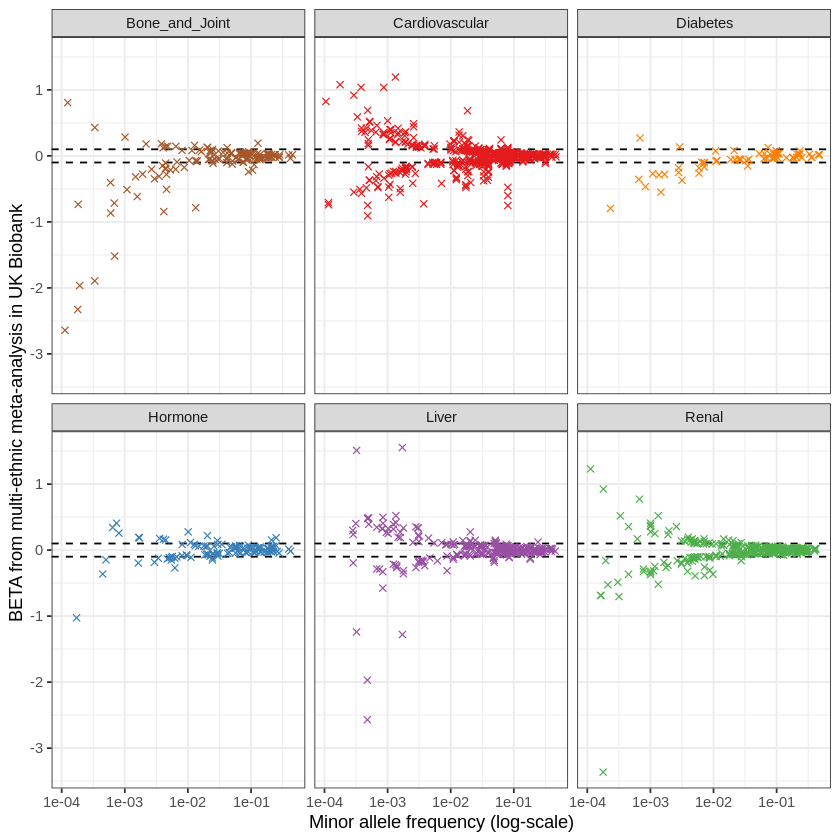

In [50]:
cascade_plot

In [51]:
ggsave('cascade.pdf', cascade_plot, width=6.5, height=8)
ggsave('cascade.png', cascade_plot, width=6.5, height=8)

## list of traits

In [44]:
legend_plot_df <- traitlist_df%>%
mutate(fuji_order=1:n()) %>%
left_join(fuji_df %>% count(TRAIT), by='TRAIT')


In [45]:
legend_plot <- legend_plot_df %>%
ggplot(aes(x=reorder(as.factor(Phenotype), -fuji_order), y=-n, color=CATEGORY, fill=CATEGORY)) +
geom_bar(stat="identity") +
theme_bw() +
coord_flip() +
scale_fill_manual(values=plot_colors) +
scale_color_manual(values=plot_colors) +
labs(
    y = '# of LD independent associations',
    x = 'trait'
) +
scale_x_discrete(position = 'top')

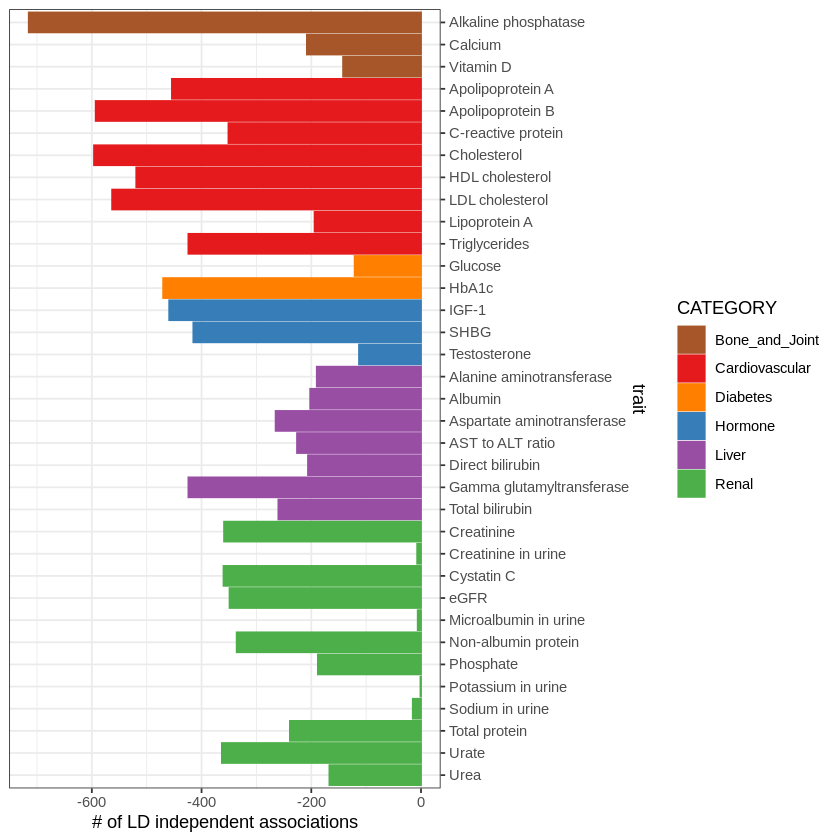

In [46]:
legend_plot 

In [48]:
ggsave('Fuji.legend.pdf', legend_plot)
ggsave('Fuji.legend.png', legend_plot)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [105]:
absBETA_plot <- df %>%
filter(Csq%in%c('PTVs', 'PAVs')) %>%
ggplot(aes(x=abs(BETA), color=CATEGORY, fill=CATEGORY)) + 
geom_vline(xintercept=0.1)+
geom_histogram(binwidth=.1) +
theme_bw() + 
scale_fill_manual(values=legend_plot_colors) +
scale_color_manual(values=legend_plot_colors) +
facet_wrap(~CATEGORY) +
labs(
    x='abs(BETA)', y='Number of coding variant associations'
) + 
theme(legend.position = 'none')


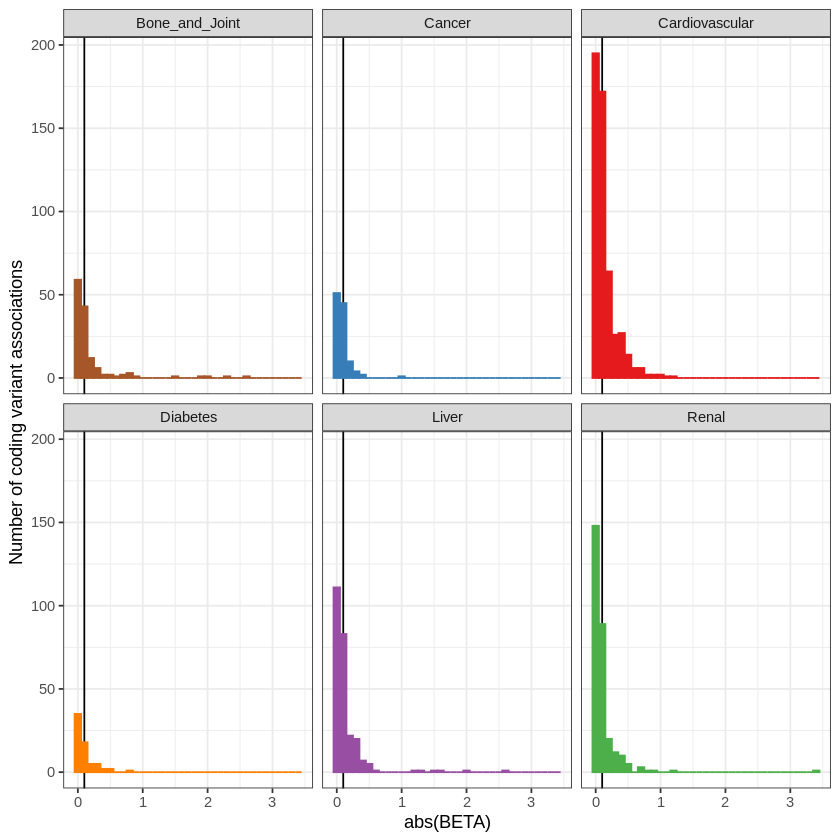

In [106]:
absBETA_plot

In [108]:
ggsave('absBETA.pdf', absBETA_plot, width=6.5, height=8)
ggsave('absBETA.png', absBETA_plot, width=6.5, height=8)

In [222]:
cascade_plot <- df %>%
filter(Csq%in%c('PTVs', 'PAVs')) %>%
# mutate(label=if_else(BETA > .5, GENE, '')) %>%
left_join(
    df %>%
    filter(Csq%in%c('PTVs', 'PAVs')) %>%
    select(MARKER, trait, GENE, BETA, CATEGORY, TRAIT) %>%
    group_by(CATEGORY) %>%
    filter(rank(BETA) <= 3 | rank(-1 * BETA) <= 3) %>%
    mutate(gglabel = T),
    by = c("MARKER", "trait", "GENE", "BETA", "CATEGORY", "TRAIT")
) %>%
mutate(
    label = if_else(gglabel,
    sprintf('%s%%~%%italic(%s)', TRAIT, GENE),
    '')
)%>%
ggplot(aes(x=MAF, y=BETA, color=CATEGORY, fill=CATEGORY, label=label)) +
geom_hline(yintercept= 0.1, linetype="dotted")+
geom_hline(yintercept=-0.1, linetype="dotted")+
geom_point()+
theme_bw() + 
scale_x_continuous(trans="log10") +
scale_fill_manual(values=legend_plot_colors) +
scale_color_manual(values=legend_plot_colors) +
ggrepel::geom_text_repel(size=2.5, parse=T, force=15)+
facet_wrap(~CATEGORY) +
labs(
    x='Minor allele frequency (log-scale)',
    y='BETA from multi-ethnic meta-analysis in UK Biobank'
) + 
theme(legend.position = 'none')


Warning message:
“Removed 1345 rows containing missing values (geom_text_repel).”

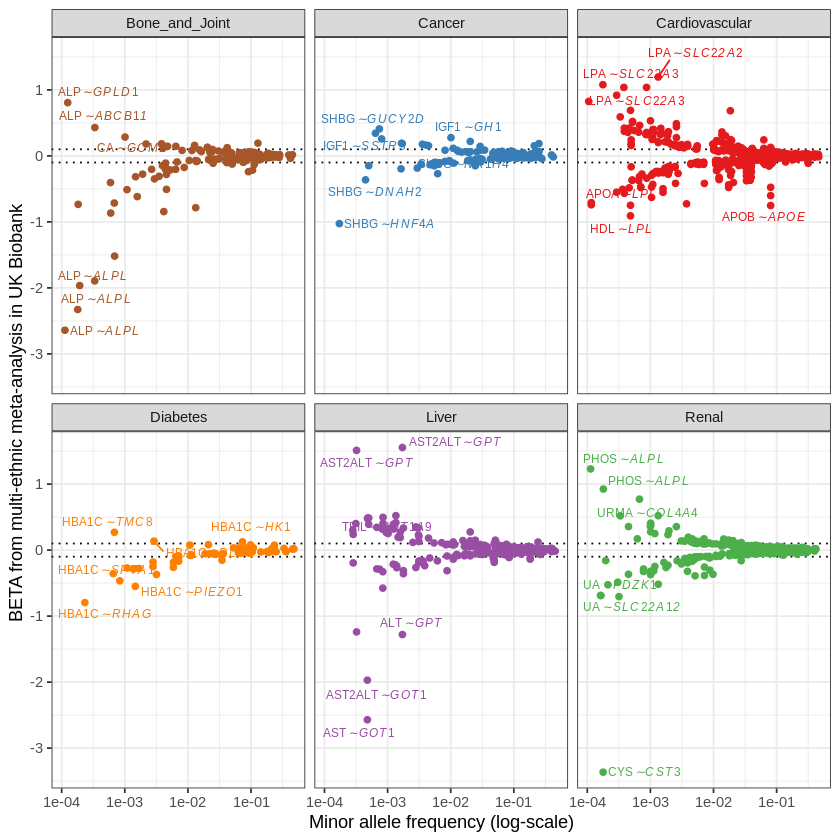

In [223]:
cascade_plot

In [224]:
ggsave('cascade.pdf', cascade_plot, width=6.5, height=8)
ggsave('cascade.png', cascade_plot, width=6.5, height=8)

Warning message:
“Removed 1345 rows containing missing values (geom_text_repel).”Warning message:
“Removed 1345 rows containing missing values (geom_text_repel).”